In [1]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    PNDMScheduler,
    LMSDiscreteScheduler,
)
import torch
from torchvision import transforms as tfms

from tqdm import tqdm, trange


from PIL import Image
import imageio
import numpy as np
from matplotlib import pyplot as plt
import inspect
import cv2
import pickle

In [2]:
# !tree /home/ubuntu/efs/diffusion/stable-diffusion-v1-5/

In [3]:
torch_device = "cuda:3"
model_dir = "/home/ubuntu/efs/diffusion/stable-diffusion-v1-5/"

## Load Models

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.


def model_fn(model_dir: str):

    # Load the tokenizer and text encoder to tokenize and encode the text.
    tokenizer = CLIPTokenizer.from_pretrained(model_dir, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_dir, subfolder="text_encoder")

    # compress image
    vae = AutoencoderKL.from_pretrained(model_dir, subfolder="vae")
    # The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained(model_dir, subfolder="unet")

    # The noise scheduler
    scheduler = LMSDiscreteScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    # To the GPU we go!
    if torch.cuda.is_available():
        vae = vae.to(torch_device)
        text_encoder = text_encoder.to(torch_device)
        unet = unet.to(torch_device)

    return tokenizer, text_encoder, vae, unet, scheduler

In [5]:
@torch.no_grad()
def pil_to_latent(vae, input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    latent = vae.encode(
            tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1
        )  # Note scaling
    return 0.18215 * latent.latent_dist.sample()

@torch.no_grad()
def latents_to_pil(vae, latents):
    # bath of latents -> list of images
    image = vae.decode((1 / 0.18215) * latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
tokenizer, text_encoder, vae, unet, scheduler = model_fn(model_dir)

## Sample Image

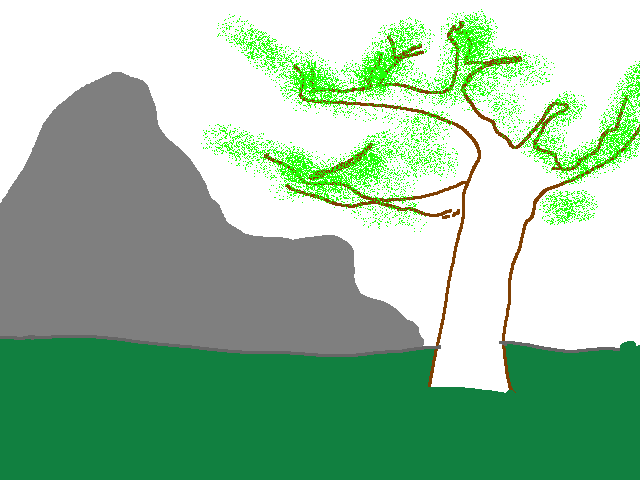

In [7]:
input_image = Image.open("trees.png").convert("RGB")#.resize((512, 512))
input_image

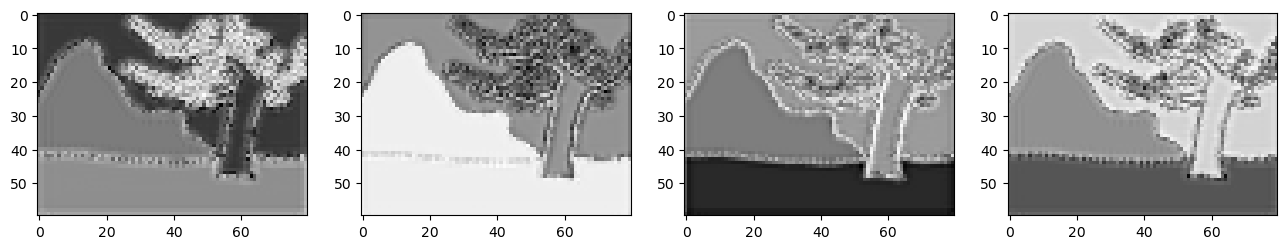

In [8]:
encoded = pil_to_latent(vae, input_image)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap="Greys")

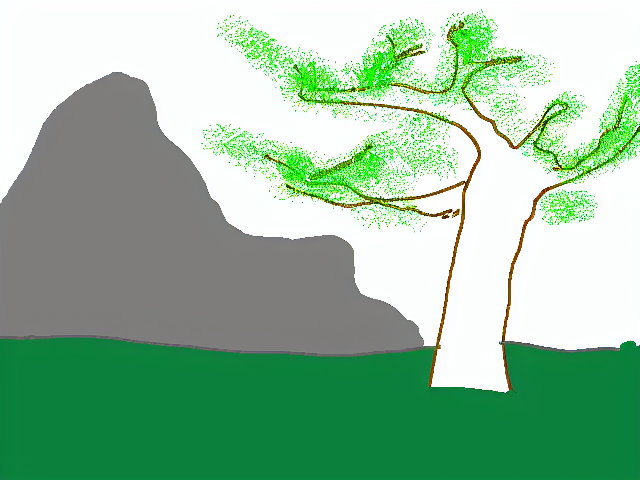

In [9]:
decoded = latents_to_pil(vae, encoded)[0]
decoded

## Function

In [10]:
@torch.no_grad()
def diffuse(
    unet,
    scheduler,
    text_embeddings,
    uncond_text_embedding,
    encoded,
    num_inference_steps: int = 50,
    strength: float = 0.1,
    guidance_scale: float = 20,
    seed: int = 666,
):
    torch_device = unet.device
    torch.manual_seed(seed)

    text_embeddings = torch.cat([uncond_text_embedding, text_embeddings])

    scheduler.set_timesteps(num_inference_steps)

    # Prep latents (noising appropriately for start_step)
    start_step = min(int(num_inference_steps * strength), num_inference_steps)
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)

    latents = scheduler.add_noise(
        encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )
    latents = latents.to(torch_device).float()

    with torch.autocast("cuda"):
        for i, t in enumerate(scheduler.timesteps):
            if i > start_step:  # << This is the only modification to the loop we do
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)
                sigma = scheduler.sigmas[i]
                latent_model_input = scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                with torch.no_grad():
                    noise_pred = unet(
                        latent_model_input, t, encoder_hidden_states=text_embeddings
                    )["sample"]

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

                # compute the previous noisy sample x_t -> x_t-1
                latents = scheduler.step(noise_pred, t, latents).prev_sample
    return latents

In [11]:
@torch.no_grad()
def tokenise_text_to_embedding(text_prompt: list, tokenizer, text_encoder):
    with torch.autocast("cuda"):
        text_tok = tokenizer(
            text_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids
        return text_encoder(text_tok.to(text_encoder.device))[0]

In [12]:
prompt = [
    "cartoonish tree in a fantasy field in front of snow mountain. \
    without leaves, bare, winter, dark, digital painting \
    by Greg Rutkowski and James Gurney, trending on Artstation, \
    highly detailed, unreal engine 5, 4K UHD image."
]

negative_prompt = ["sunshine, leaves, green, daylight"]

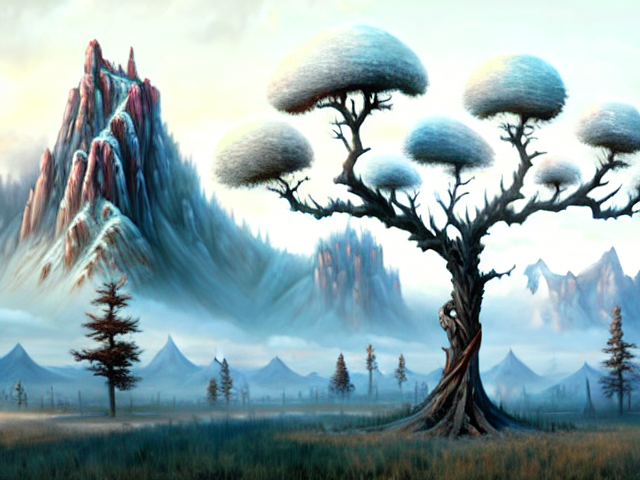

In [13]:
# Prep text (same as before)
text_embeddings = tokenise_text_to_embedding(prompt, tokenizer, text_encoder)
uncond_embeddings = tokenise_text_to_embedding(negative_prompt, tokenizer, text_encoder)
latents = diffuse(
    unet,
    scheduler,
    text_embeddings,
    uncond_embeddings,
    encoded,
    num_inference_steps=70,
    strength=0.2,
    guidance_scale=40,
    seed=666,
)
latents_to_pil(vae, latents)[0]

## SLERP

In [14]:
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

## Animation

In [15]:
prompts = [
    "cartoonish tree in a winter field in front of snow mountain. without leaves, \
bare, winter, dark, digital painting by Greg Rutkowski and James Gurney, \
trending on Artstation, highly detailed, unreal engine 5, 4K UHD image.",
    "cartoonish tree in a fantasy field in front of snow mountain. \
without leaves, bare, winter, dark, digital painting \
by Greg Rutkowski and James Gurney, trending on Artstation, \
highly detailed, unreal engine 5, 4K UHD image.",
    "cartoonish tree in a fantasy field in front of snow mountain. \
night, overlooking full moon, a fantasy digit painting \
by Greg Rutkowski and James Gurney, trending on Artstation, \
highly detailed, unreal engine 5, 4K UHD image.",
    "cartoonish tree in a fantasy field in front of snow mountain. \
without leaves, bare, winter, dark, digital painting \
by Greg Rutkowski and James Gurney, trending on Artstation, \
highly detailed, unreal engine 5, 4K UHD image.",
    "tree in a fantasy field in front of snow mountain. \
full of green leaves, lush, summer, sunny, Hayao Miyazaki anime style, 4K UHD image.",
    "Oak Tree in a fantasy field in front of snow mountain. \
full of green leaves, lush, summer, sunny, digital painting \
by Greg Rutkowski and James Gurney, trending on Artstation, \
highly detailed, unreal engine 5, 4K UHD image.",
]
negative_prompts = [""]*len(prompts)

for idx in [0, 1, 2, 3]:
    negative_prompts[idx] = "sunshine, leaves, green, daylight"

input_images = [input_image]*len(prompts)

In [16]:
prompt_embeddings = []
negative_prompt_embeddings = []
image_embeddings = []
for prompt, neg_prompt, image in zip(prompts, negative_prompts, input_images):
    prompt_embeddings.append(
        tokenise_text_to_embedding(prompt, tokenizer, text_encoder)
    )
    negative_prompt_embeddings.append(
        tokenise_text_to_embedding(neg_prompt, tokenizer, text_encoder)
    )
    image_embeddings.append(pil_to_latent(vae, image))

In [17]:
prompt_embedding_a, *prompt_embeddings = prompt_embeddings
negative_prompts_a, *negative_prompt_embeddings = negative_prompt_embeddings
image_embeddings_a, *image_embeddings = image_embeddings

In [18]:
numsteps = 40
latents = []
for idx, (prompt, neg_prompt, image) in enumerate(
    zip(prompt_embeddings, negative_prompt_embeddings, image_embeddings)
):
    print(idx)

    for i, t in enumerate(np.linspace(0, 1, numsteps)):
        
        print(i, end="-")
        
        cond_embedding = slerp(float(t), prompt_embedding_a, prompt)
        uncond_embedding = slerp(float(t), negative_prompts_a, neg_prompt)
        image_embedding = slerp(float(t), image_embeddings_a, image)

        latent = diffuse(
            unet,
            scheduler,
            cond_embedding,
            uncond_embedding,
            image_embedding,
            num_inference_steps=70,
            strength=0.2,
            guidance_scale=40,
            seed=666,
        )
        latents.append(latents_to_pil(vae, latent)[0])
        
    print("end")

    prompt_embedding_a = prompt
    negative_prompts_a = neg_prompt
    image_embeddings_a = image

0
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-end
1
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-end
2
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-end
3
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-end
4
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-end


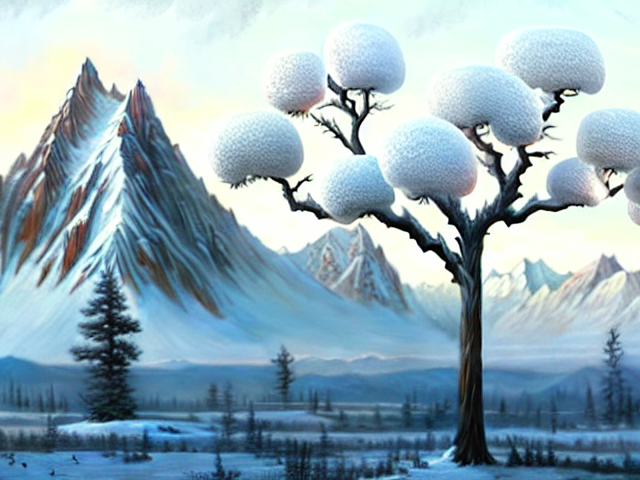

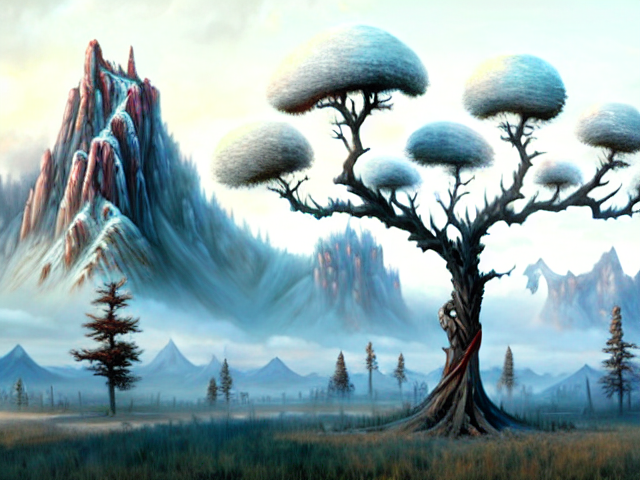

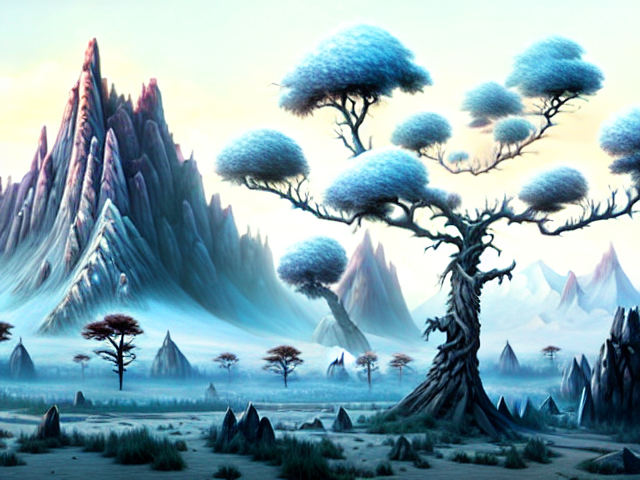

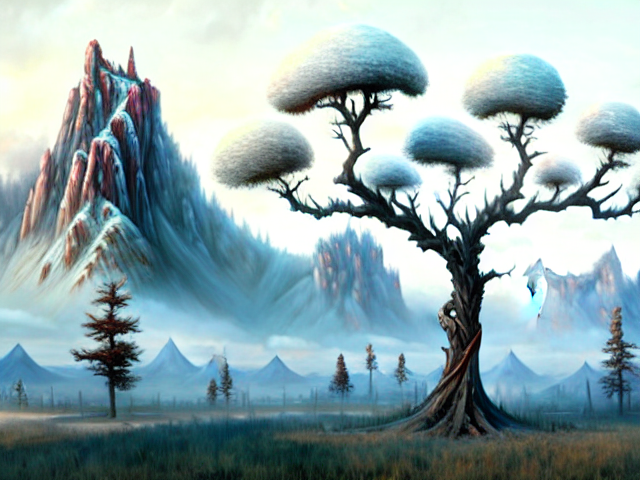

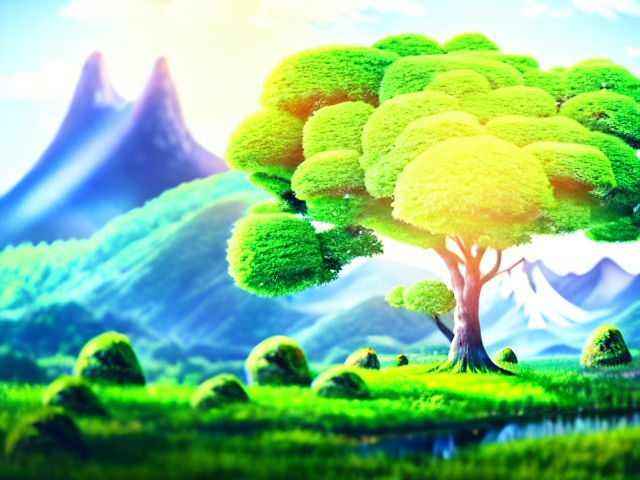

In [25]:
for lt in latents[::40]:
    lt.show()

In [26]:
len(latents)

200

## Save to Video

In [27]:
def dist(x1, x2):
    x1 = cv2.resize(
        np.array(x1), (0, 0), fx=0.375, fy=0.375, interpolation=cv2.INTER_AREA
    )
    x2 = cv2.resize(
        np.array(x2), (0, 0), fx=0.375, fy=0.375, interpolation=cv2.INTER_AREA
    )

    return ((x1 - x2) ** 2).mean()

In [53]:
video_fps = (
    10  # adjust this based on how long you ran the interpolation for and how it looks
)

file_name = "TREE.mp4"

with imageio.get_writer(file_name, fps=video_fps) as wr:

    for c in trange(80, len(latents)-40):
        frame = latents[c]

        last_written_frame = np.array(frame) if c == 0 else next_frame_to_write
        next_frame_to_write = np.array(frame)

        n_reps = max(round(np.sqrt(dist(last_written_frame, next_frame_to_write))), 1)
        for i in range(n_reps):
            wr.append_data(next_frame_to_write)

        c += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 28.77it/s]


In [55]:
from IPython.display import Video
Video(file_name)

## Reference

1. https://github.com/fastai/diffusion-nbs
1. https://github.com/schmidtdominik/stablediffusion-interpolation-tools
1. https://gist.github.com/nateraw/c989468b74c616ebbc6474aa8cdd9e53
2. https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355